# HOME ASSIGNMENT #5: BIGQUERY SQL & PYTHON PANDAS

**Mục đích của bài Assignment**
> *  Upload Data từ Google Spreadsheet lên BigQuery và thao tác data với SQL
*  Thao tác với data bằng Pandas
*   `[Optional]` Data Visualization on Python

**Các kiến thức áp dụng**
* Slack API, JSON to DataFrame
* Google Spreadsheet to BigQuery
* SQL
* Python Pandas

**Lời Khuyên**
* Đây là bài tập nhẹ nhàng hơn các tuần trước
* Các bạn dành thời gian ôn lại và xâu chuỗi kiến thức

# TODO 1: BIGQUERY & SQL
* Làm theo Lab của Week 5: [HERE](https://anhdang.gitbook.io/datacracy/atom/5-sql-and-database-design/5.2-lab-upload-data-tu-google-sheet-to-bigquery)

In [39]:
# Import Library
import requests #-> Để gọi API
import re #-> Để xử lý data dạng string
from datetime import datetime as dt #-> Để xử lý data dạng datetime
import gspread #-> Để update data lên Google Spreadsheet
from gspread_dataframe import set_with_dataframe #-> Để update data lên Google Spreadsheet
import pandas as pd #-> Để update data dạng bản
import json 
import numpy as np
#from oauth2client.service_account import ServiceAccountCredentials #-> Để nhập Google Spreadsheet Credentials
from oauth2client.service_account import ServiceAccountCredentials
import os

In [25]:
# load environment varaibles
with open('env_variable.json','r') as j:
    json_data = json.load(j)
    
# load slack_Bearer_token
os.environ['SLACK_BEARER_TOKEN'] = json_data['SLACK_BEARER_TOKEN']
#print(os.environ['SLACK_BEARER_TOKEN'] )

In [125]:
# Function to pull Slack Data
def extract_SlackUsers(user_dat):
    '''Return desired information of the given Slack Users list in  DataFrame format
    
    '''
    #Extract data from user_dat into user_df
    user_dict = {'user_id':[],'name':[],'display_name':[],'real_name':[],'title':[],'is_bot':[]}
    for i in range(len(user_dat)):
        user_dict['user_id'].append(user_dat[i]['id'])
        user_dict['name'].append(user_dat[i]['name'])
        user_dict['display_name'].append(user_dat[i]['profile']['display_name'])
        user_dict['real_name'].append(user_dat[i]['profile']['real_name_normalized'])
        user_dict['title'].append(user_dat[i]['profile']['title'])
        user_dict['is_bot'].append(user_dat[i]['is_bot'])

    user_df = pd.DataFrame(user_dict) 
    user_df = user_df.replace('', np.nan) # -> replace khoảng trắng bằng giá trị NULL (nan)
    return user_df

def extract_SlackChannels(channel_dat):
    '''Return desired information of the given Slack Channels list in  DataFrame format
    
    '''
    #Extract data from channel_ls into channel_df

    channel_dict = {'channel_id':[], 'channel_name':[], 'is_channel':[],'creator':[],'created_at':[],'topics':[],'purpose':[],'num_members':[]}
    for i in range(len(channel_dat)):
        channel_dict['channel_id'].append(channel_dat[i]['id'])
        channel_dict['channel_name'].append(channel_dat[i]['name'])
        channel_dict['is_channel'].append(channel_dat[i]['is_channel'])
        channel_dict['creator'].append(channel_dat[i]['creator'])
        channel_dict['created_at'].append(dt.fromtimestamp(float(channel_dat[i]['created'])))
        channel_dict['topics'].append(channel_dat[i]['topic']['value'])
        channel_dict['purpose'].append(channel_dat[i]['purpose']['value'])
        channel_dict['num_members'].append(channel_dat[i]['num_members'])

    channel_df = pd.DataFrame(channel_dict) 
    channel_df = channel_df.replace('', np.nan) # -> replace khoảng trắng bằng giá trị NULL (nan)
    return channel_df

def extract_SlackMessages(msg_endpoint, headers):
    '''Return desired information of Slack messages in  DataFrame format
    '''
    ## 1. request Slack API to get messages
    msg_dict = {'channel_id':[],'msg_id':[], 'msg_ts':[], 'user_id':[], 'latest_reply':[],'reply_user_count':[],'reply_users':[],'github_link':[]}
    for channel_id, channel_name in zip(channel_df['channel_id'], channel_df['channel_name']):
#         print('Channel ID: {} - Channel Name: {}'.format(channel_id, channel_name))
        try:
            data = {"channel": channel_id} 
            response_json = requests.post(msg_endpoint, data=data, headers=headers).json()
            msg_ls = response_json['messages']
            for i in range(len(msg_ls)):
                if 'client_msg_id' in msg_ls[i].keys():
                    msg_dict['channel_id'].append(channel_id)
                    msg_dict['msg_id'].append(msg_ls[i]['client_msg_id'])
                    msg_dict['msg_ts'].append(dt.fromtimestamp(float(msg_ls[i]['ts'])))
                    msg_dict['latest_reply'].append(dt.fromtimestamp(float(msg_ls[i]['latest_reply'] if 'latest_reply' in msg_ls[i].keys() else 0))) ## -> No reply: 1970-01-01
                    msg_dict['user_id'].append(msg_ls[i]['user'])
                    msg_dict['reply_user_count'].append(msg_ls[i]['reply_users_count'] if 'reply_users_count' in msg_ls[i].keys() else 0)
                    msg_dict['reply_users'].append(msg_ls[i]['reply_users'] if 'reply_users' in msg_ls[i].keys() else 0) 
                    ## -> Censor message contains tokens
                    text = msg_ls[i]['text']
                    github_link = re.findall('(?:https?://)?(?:www[.])?github[.]com/[\w-]+/?', text)
                    msg_dict['github_link'].append(github_link[0] if len(github_link) > 0 else np.nan)
        except:
            print('====> '+ str(response_json))
    msg_df = pd.DataFrame(msg_dict)
    msg_df = msg_df.replace('', np.nan) # -> replace khoảng trắng bằng giá trị NULL (nan)
    return(msg_df)

In [126]:
# Functions to upload data to Gsheet
def authorize_gspread(json_keyfile_name = 'diesel-post-314008-065a1771ca30.json' ):
    
    '''Return google credentials to access gsheet by  authorizing with given json_keyfile_name
    '''
    ##1. Authorize bằng JSON
    scope = ['https://spreadsheets.google.com/feeds',
             'https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name(
        json_keyfile_name , scope)
    gc = gspread.authorize(credentials)
    print("DONE!")
    return(gc)

def append_data_to_sheet(sh, sheet_name, data_df):
    '''Append data_df to sheet_name. If sheet_name already existed, the data in this sheet will be overwriten.
    '''
    try:
        worksheet = sh.worksheet(sheet_name)
#         print('tìm thấy')
    except:
#         print("khong thấy")
        num_row = data_df.shape[0]
        num_col = data_df.shape[1]
        worksheet = sh.add_worksheet(title = sheet_name, rows= num_row, cols= num_col)
    finally:
        set_with_dataframe(worksheet, data_df) #-> Upload data_df vào workSheet trong Spreadsheet
        print("Done! {} was uploaded!".format(sheet_name))
    

In [58]:
# M A I N 
#(1) Code để pull Slack Data
## init user and msg data request
headers = {"Authorization": "Bearer {}".format(os.environ['SLACK_BEARER_TOKEN'])}

users_endpoint = "https://slack.com/api/users.list"
channel_endpoint = "https://slack.com/api/conversations.list"
msg_endpoint = "https://slack.com/api/conversations.history"


#1.Users
## 1.1 Request Slack API to get users
response_json = requests.post(users_endpoint, headers=headers).json()
user_dat = response_json['members']
## 1.2 Extract user infomation
user_df = {}
user_df = extract_SlackUsers(user_dat)

#2. Channels
## 2.1 Request Slack API to get channels
response_json = requests.post(channel_endpoint, headers=headers).json()
channel_dat = response_json['channels']
## 2.2 Extract channel infomation
channel_df = {}
channel_df  = extract_SlackChannels(channel_dat)

#3.Messages -  request Slack API and extract data
msg_df = {}
msg_df = extract_SlackMessages(msg_endpoint, headers)



====> {'ok': False, 'error': 'not_in_channel'}
====> {'ok': False, 'error': 'not_in_channel'}
====> {'ok': False, 'error': 'not_in_channel'}
====> {'ok': False, 'error': 'not_in_channel'}
====> {'ok': False, 'error': 'not_in_channel'}


In [127]:
#(2) Code để upload data lên Gsheet

##1. Authorize bằng JSON
gc = authorize_gspread()

##2. ACCES GOOGLE SHEET with given spreadsheet_key
spreadsheet_key = '1G4q0qH3Bm1IOFjVCbqlHQGpiC2YumiGqkZNq7V-eyNI' # input SPREADSHEET_KEY HERE
sh = gc.open_by_key(spreadsheet_key)

##3. Append data to sheets
append_data_to_sheet(sh, 'user_df', user_df)
append_data_to_sheet(sh, 'channel_df', channel_df)
append_data_to_sheet(sh, 'msg_df', msg_df)

DONE!
Done! user_df was uploaded!
Done! channel_df was uploaded!
Done! msg_df was uploaded!


#Todo#1
GSpresdSheet chứa Slack Data (user_df, channel_df, msg_df) [HERE](https://docs.google.com/spreadsheets/d/1G4q0qH3Bm1IOFjVCbqlHQGpiC2YumiGqkZNq7V-eyNI/edit?usp=sharing)

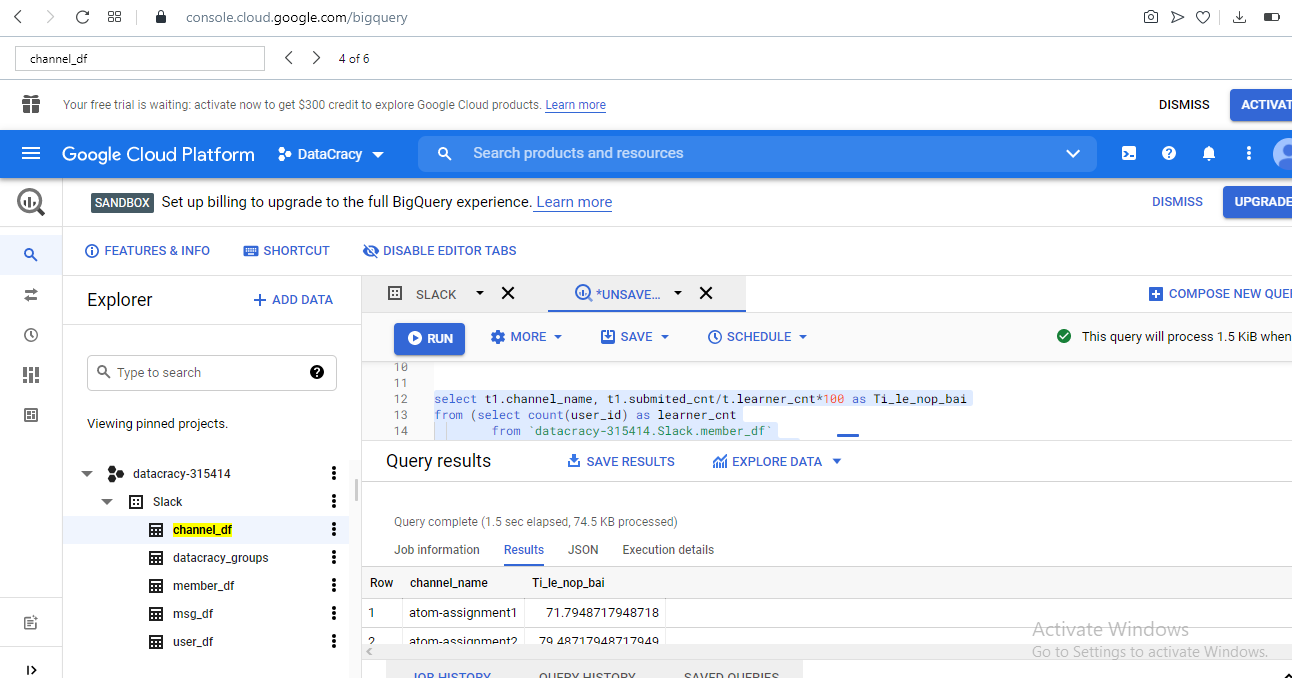

In [128]:
from IPython.display import Image
Image('img/bigQuery.png')

# TODO 2: Python Pandas
[Kaggle](https://www.kaggle.com/) là cộng đồng lớn nhất thế giới về Data Science với các cuộc thi/thử thách ML, các công cụ và tài liệu để học và phát triển kỹ năng
* Tạo account của bạn trên Kaggle
* Coi tutorial và làm 6 sets bài tập trên Kaggle [HERE](https://www.kaggle.com/learn/pandas)
* Bạn có thể làm bài trực tiếp trên Kaggle (cũng là dạng notebook online như Colab). Toàn bộ notebook sẽ lưu trên phần Code trong Profile Account của bạn
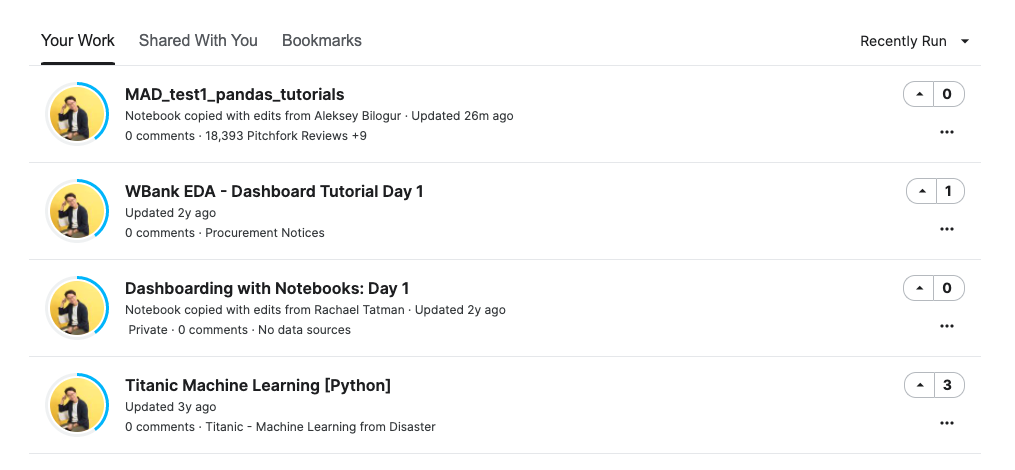

# TODO 3: Python Pandas 
Trở lại TODO7 [Assignment#4](https://github.com/anhdanggit/atom-assignments/blob/main/assignment_4/home_assignment_4.ipynb) (nếu bạn chưa hoàn thành)

In [151]:
## TODO3: Modify lại Assignment#4 TODO#7
# datacracy groups
dtc_groups = pd.read_csv('datacracy_groups.csv')

# members : chứa dữ liệu tương tự bảng members_df ở trên phần SQL
members = user_df.join(other = dtc_groups.set_index('name'), on = 'name', how = 'left')

# danh sách học viên
is_learner = members['DataCracy_role'].str.startswith('Learner').fillna(False)
learners = members[is_learner]

# lọc kênh nộp bài
is_assigment_channel = channel_df['channel_name'].str.startswith('atom-assignment').fillna(False)
assigment_channels = channel_df[is_assigment_channel]

# Lọc ra message trong các channel nộp bài của học viên
learner_msg = msg_df.join(other = learners.set_index('user_id'), on = 'user_id',how = 'inner')

learner_assignment_msg = learner_msg.join(other = assigment_channels.set_index('channel_id'), on = 'channel_id', how = 'inner')
learner_assignment_msg.head(1)

# Lọc mgs nộp bài
is_attached = learner_assignment_msg['github_link'].notnull()
submitters = learner_assignment_msg[is_attached]

In [152]:
print("Những bạn nộp bài sớm nhất:")
first_submitters = submitters.groupby(['channel_name']).apply(lambda df: df.loc[df.msg_ts.idxmin()])
first_submitters[['user_id','display_name','DataCracy_role', 'msg_ts','github_link' ]]

Những bạn nộp bài sớm nhất:


,user_id,display_name,DataCracy_role,msg_ts,github_link
channel_name,,,,,
atom-assignment1,U01UMJ5AQ0K,Dương Phan Nam Hưng,Learner_Gr1,2021-04-21 13:00:34.000800,https://github.com/duongphannamhung/
atom-assignment2,U01UQGZHSTZ,Toan Tran,Learner_Gr2,2021-05-12 22:50:48.004000,https://github.com/toantran2206/
atom-assignment3,U01UTGRMGEQ,Nguyen Hong Hanh,Learner_Gr4,2021-05-16 19:08:08.018900,https://github.com/nguyenhonghanh2511/
atom-assignment4,U01UJ9M3P1T,Cao Nguyen Huy Hoang,Learner_Gr2,2021-05-26 00:46:52.015200,https://github.com/cnhhoang850/


In [153]:
print("Những bạn nộp bài muộn nhất:")
last_submitters = submitters.groupby(['channel_name']).apply(lambda df: df.loc[df.msg_ts.idxmax()])
last_submitters[['user_id','display_name','DataCracy_role', 'msg_ts','github_link' ]]

Những bạn nộp bài muộn nhất:


,user_id,display_name,DataCracy_role,msg_ts,github_link
channel_name,,,,,
atom-assignment1,U01UJ9LG5U5,Danh Phan,Learner_Gr3,2021-05-10 11:51:46.004700,https://github.com/danhpcv/
atom-assignment2,U01UTGRMGEQ,Nguyen Hong Hanh,Learner_Gr4,2021-05-22 12:39:34.015500,https://github.com/nguyenhonghanh2511/
atom-assignment3,U01USGKQ771,Trang,Learner_Gr1,2021-05-27 22:30:16.003200,https://github.com/TrangNgo1709/
atom-assignment4,U01UTGRMGEQ,Nguyen Hong Hanh,Learner_Gr4,2021-05-30 20:34:16.003700,https://github.com/nguyenhonghanh2511/


# TODO 4 (OPTIONAL): Python Data Viz
Coi tutorial và làm nhiều nhất có thể các sets bài tập trên [Kaggle Data Visualization](https://www.kaggle.com/learn/data-visualization)

In [ ]:
# Copy Link tới các bài tập
## DataViz 1: --->
## DataViz 2: --->
## DataViz 3: --->
## DataViz 4: --->
## DataViz 5: --->
## DataViz 6: --->
## DataViz 7: --->